# NMR Spectra simulation

## Install required python modules

In [24]:
%%bash
pip install -e ../.

Obtaining file:///data/ar1220/MscProjectNMR
  Attempting uninstall: MscProjectNMR
    Found existing installation: MscProjectNMR 0
    Uninstalling MscProjectNMR-0:
      Successfully uninstalled MscProjectNMR-0
  Running setup.py develop for MscProjectNMR


In [ ]:
%%bash
pip install -r ../requirements.txt

## Import data

In [1]:
import numpy as np

filename_control = '../data/Simulation/Spectra_Mixt1.txt'
filename_case = '../data/Simulation/Spectra_Mix2.txt'
data_control = np.loadtxt(filename_control, dtype=float)
data_case = np.loadtxt(filename_case, dtype=float)

In [2]:
#Convert into dataframes
import pandas as pd

df_control = pd.DataFrame(data_control).T
df_case = pd.DataFrame(data_case).T

#Concatenate control and case df
df_NMR_intensities = pd.concat([df_control, df_case])
df_status = [0] * df_control.shape[0] + [1] * df_case.shape[0]

In [3]:
#Convert into tf.data
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((df_NMR_intensities, df_status))
dataset.element_spec

(TensorSpec(shape=(10000,), dtype=tf.float64, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

## Write tf.Record

In [4]:
from tfrecords import write_tfrecords

In [5]:
write_tfrecords(dataset)

## Read the file

In [6]:
from tfrecords import read_tfrecords

In [7]:
file_paths = ['../data/tfrecords/data_{}.tfrecord'.format(i) for i in range(20)]
full_dataset = read_tfrecords(file_paths)

# for parsed_record in full_dataset.shuffle(20000).batch(32).take(5):
#     print((model(parsed_record[0]), parsed_record[1]))

## Process data

In [8]:
from models import process_dataset

In [9]:
train_dataset, val_dataset, test_dataset = process_dataset(full_dataset, batch_sizes=[64] * 3, shuffle_buffers=[20000] * 3,
                                                           train_prop=0.8, val_prop=0.2)

## Define Checkpoint

In [15]:
from models import CheckpointCallback

# Create a CheckpointCallback to save the model    
ckpt = CheckpointCallback("../saved_models")

## Define MLP

In [16]:
from models import get_simple_mlp

simple_model = get_simple_mlp(input_shape=(10000,), hidden_units=[16, 16])
simple_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_11 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 17        
Total params: 160,305
Trainable params: 160,305
Non-trainable params: 0
_________________________________________________________________


In [17]:
from models import get_regularised_bn_dropout_mlp

regularised_bn_dropout_model = get_regularised_bn_dropout_mlp(input_shape=(10000,), hidden_units=[1024, 1024, 1024, 512, 512, 512],
                                l2_reg_coeff=0.0001, dropout_rate=0.5)
regularised_bn_dropout_model.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense_13 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
batch_normalization_6 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_7 (Batch (None, 1024)              4096      
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)             

## Compile models

In [18]:
opt = tf.keras.optimizers.Adam(lr=0.0005)
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
acc = tf.keras.metrics.BinaryAccuracy()
earlystopping = tf.keras.callbacks.EarlyStopping(patience=200)

In [19]:
regularised_bn_dropout_model.compile(optimizer=opt, loss=loss, metrics=[acc])
history = regularised_bn_dropout_model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[ckpt])

Epoch 1/10
250/250 [==============================] - 20s 81ms/step - loss: 0.4915 - binary_accuracy: 0.9911 - val_loss: 0.4084 - val_binary_accuracy: 1.0000
Epoch 2/10
250/250 [==============================] - 17s 69ms/step - loss: 0.3939 - binary_accuracy: 0.9966 - val_loss: 0.3546 - val_binary_accuracy: 1.0000
Epoch 3/10
250/250 [==============================] - 18s 72ms/step - loss: 0.3492 - binary_accuracy: 0.9970 - val_loss: 0.3188 - val_binary_accuracy: 1.0000
Epoch 4/10
250/250 [==============================] - 16s 65ms/step - loss: 0.3029 - binary_accuracy: 0.9992 - val_loss: 0.2806 - val_binary_accuracy: 1.0000
Epoch 5/10
250/250 [==============================] - 16s 64ms/step - loss: 0.2741 - binary_accuracy: 0.9984 - val_loss: 0.2511 - val_binary_accuracy: 1.0000
Epoch 6/10
250/250 [==============================] - 15s 59ms/step - loss: 0.2498 - binary_accuracy: 0.9972 - val_loss: 0.2252 - val_binary_accuracy: 1.0000
Epoch 7/10
250/250 [==============================] 

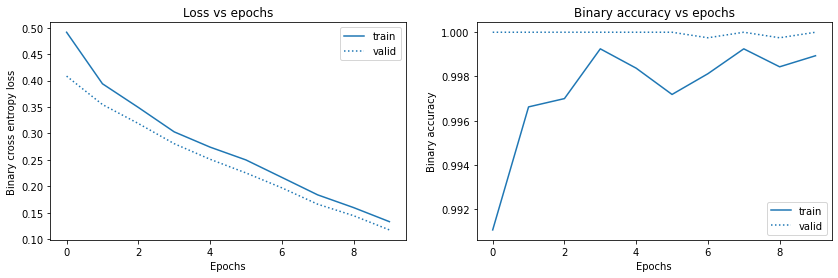

In [20]:
# Plot the learning curves

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(history.history['loss'], label='train', color='C0', linestyle='-')
plt.plot(history.history['val_loss'], label='valid', color='C0', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary cross entropy loss")
plt.legend()

fig.add_subplot(122)
plt.plot(history.history['binary_accuracy'], label='train', color='C0', linestyle='-')
plt.plot(history.history['val_binary_accuracy'], label='valid', color='C0', linestyle=':')
plt.title("Binary accuracy vs epochs")
plt.xlabel("Epochs")
plt.ylabel("Binary accuracy")
plt.legend()

plt.show()